# OpenGesture-AWS-Habana

## Machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model



### We will start by verify that AWS EC2 dl1.24xlarge instance is working:

In [30]:
!hl-smi

+-----------------------------------------------------------------------------+
| HL-SMI Version:                               hl-1.2.0-fw-32.5.0.0          |
| Driver Version:                                      1.2.0-124dd38          |
|-------------------------------+----------------------+----------------------+
| AIP  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | AIP-Util  Compute M. |
|===============================+======================+======================|
|   0  HL-205              N/A  | 0000:10:1d.0     N/A |                   0  |
| N/A   54C   N/A   110W / 350W |    512Mib / 32768Mib |     5%           N/A |
|-------------------------------+----------------------+----------------------+
|   1  HL-205              N/A  | 0000:10:1e.0     N/A |                   0  |
| N/A   57C   N/A   106W / 350W |    512Mib / 32768Mib |     3%           N/A |
|-------------------------------+-------

### Import TensorFlow and other libraries

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Import Habana Modules for TensorFlow

In [32]:
from habana_frameworks.tensorflow import load_habana_module

### Download and explore the dataset - OpenGesture Dataset colleceted using Intel RealSense D435

In [5]:
import pathlib
dataset_url = "https://planetg.s3.amazonaws.com/opengesture-data.tar.xz"
data_dir = tf.keras.utils.get_file('opengesture-data', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

379576320/379565684 [==============================] - 7s 0us/step


### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the load images tutorial.

### Create a dataset
Define some parameters for the loader:



In [33]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

600


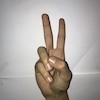

In [34]:
roses = list(data_dir.glob('two/*'))
PIL.Image.open(str(roses[0]))

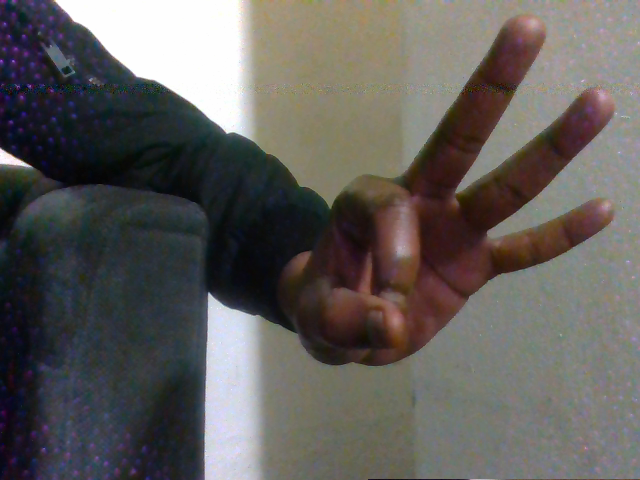

In [8]:
tulips = list(data_dir.glob('nine/*'))
PIL.Image.open(str(tulips[0]))

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [35]:
batch_size = 32
img_height = 180
img_width = 180

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2662 files belonging to 10 classes.
Using 2130 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2662 files belonging to 10 classes.
Using 532 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [38]:
class_names = train_ds.class_names
print(class_names)

['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']


Visualize the data
Here are the first 9 images from the training dataset.

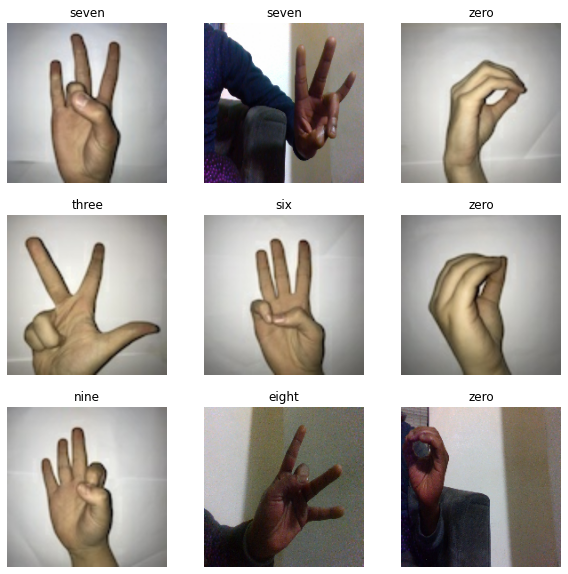

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Train a model using these datasets by passing them to model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer

In [42]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [43]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9716775


### Data augmentation
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside your model like other layers, and run on the GPU.

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

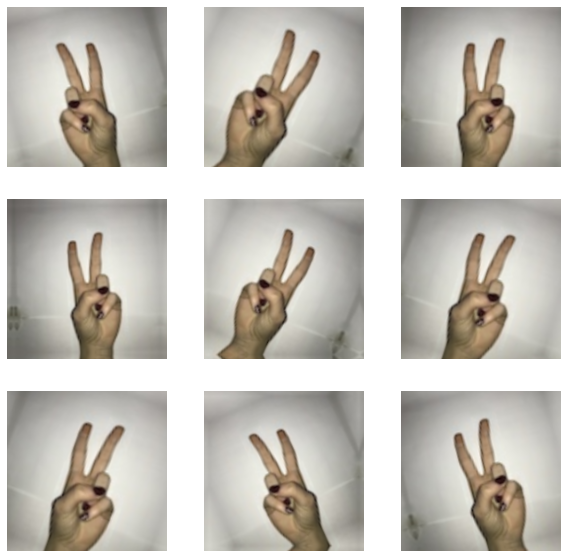

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

### Dropout
Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [46]:
num_classes = 20

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile and train the model

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [54]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
67/67 [==============================] - 7s 93ms/step - loss: 0.6778 - accuracy: 0.7634 - val_loss: 0.7035 - val_accuracy: 0.7500
Epoch 2/20
67/67 [==============================] - 6s 88ms/step - loss: 0.6548 - accuracy: 0.7709 - val_loss: 0.6023 - val_accuracy: 0.7857
Epoch 3/20
67/67 [==============================] - 6s 89ms/step - loss: 0.5538 - accuracy: 0.8127 - val_loss: 0.5690 - val_accuracy: 0.8083
Epoch 4/20
67/67 [==============================] - 6s 89ms/step - loss: 0.5672 - accuracy: 0.8108 - val_loss: 0.6020 - val_accuracy: 0.8139
Epoch 5/20
67/67 [==============================] - 6s 89ms/step - loss: 0.5560 - accuracy: 0.8169 - val_loss: 0.5649 - val_accuracy: 0.8158
Epoch 6/20
67/67 [==============================] - 6s 88ms/step - loss: 0.5140 - accuracy: 0.8197 - val_loss: 0.5598 - val_accuracy: 0.8177
Epoch 7/20
67/67 [==============================] - 6s 87ms/step - loss: 0.4800 - accuracy: 0.8333 - val_loss: 0.5178 - val_accuracy: 0.8515
Epoch 8/20
67

### Visualize training results
After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

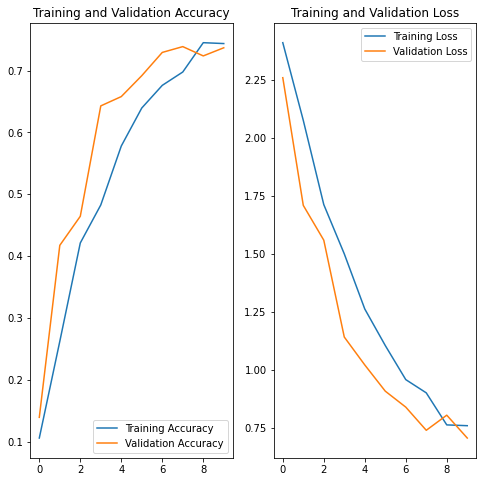

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data
Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [51]:
sunflower_url = "https://planetg.s3.amazonaws.com/7a_Color.png"
sunflower_path = tf.keras.utils.get_file('7a_Color', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to seven with a 51.26 percent confidence.
